## Ejercicio 5. 
Para este ejercicio utilizaremos el dataset EuRoc.

Descargue el archivo ground-truth (trayectoria real realizada por el robot) localizado http://robotics.ethz.ch/~asl-datasets/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/MH_01_easy.zip.

Nota: Para la descarga se recomienda utilizar el programa aria2c con los parámetros: aria2c -s N -xN < URL>, con N la cantidad de cores en su computadora.

a) El ground-truth se encuentra en coordenadas de la IMU (Body). Se pide crear un script en python que dada la trayectoría ground-truth (timestamp, x, y, z, qw, qx, qy, qz) (primeras 8 columnas del archivo mav0/state_groundtruth_estimate0/data.csv) genere el camino ground-truth de la cámara izquierda, esté debe estar dado en el sistema de coordenadas de la cámara izquierda inicial. Para esto deberá utilizar las transformaciones provistas en el dataset.

b) Modifique el script para que el timestamp del nuevo ground-truth este en segundos con precisión de nanosegundos. Agregar las primeras 5 filas del ground-truth resultante y las del original del dataset al informe.

c) Modifique el script para que genere una imagen con ambos ground-truth (el camino de la IMU y el camino de la cámara). Aplique las transformaciones necesaria para que ambos caminos esten en el sisma de coordenadas del ground-truth original. Agregar la imagen al informe.

Los datos de la trayetoria fueron tomados con el robot Asctec Firefly MAV:

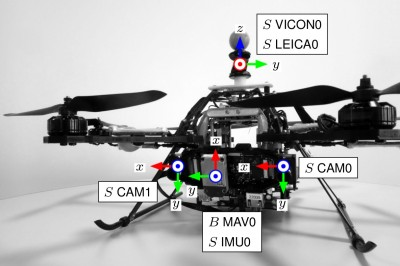

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# -------------------------------
# Cargar CSV
# -------------------------------
# Asegurate de que tu CSV tenga cabeceras: timestamp,x,y,z,qw,qx,qy,qz
df = pd.read_csv("C:/Users/Geronimo/Downloads/mav0/state_groundtruth_estimate0/data.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36382 entries, 0 to 36381
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   #timestamp              36382 non-null  int64  
 1    p_RS_R_x [m]           36382 non-null  float64
 2    p_RS_R_y [m]           36382 non-null  float64
 3    p_RS_R_z [m]           36382 non-null  float64
 4    q_RS_w []              36382 non-null  float64
 5    q_RS_x []              36382 non-null  float64
 6    q_RS_y []              36382 non-null  float64
 7    q_RS_z []              36382 non-null  float64
 8    v_RS_R_x [m s^-1]      36382 non-null  float64
 9    v_RS_R_y [m s^-1]      36382 non-null  float64
 10   v_RS_R_z [m s^-1]      36382 non-null  float64
 11   b_w_RS_S_x [rad s^-1]  36382 non-null  float64
 12   b_w_RS_S_y [rad s^-1]  36382 non-null  float64
 13   b_w_RS_S_z [rad s^-1]  36382 non-null  float64
 14   b_a_RS_S_x [m s^-2]    36382 non-null

Extraigo las posiciones y orientaciones del ground-truth

In [4]:
positions = df[[" p_RS_R_x [m]", " p_RS_R_y [m]", " p_RS_R_z [m]"]].values
quaternions = df[[" q_RS_x []", " q_RS_y []", " q_RS_z []", " q_RS_w []"]].values  # ojo: scipy usa (x,y,z,w)

# Normalizar tiempo (opcional: que empiece en 0)
time = df["#timestamp"] - df["#timestamp"].iloc[0]

Grafico las trayectorias en 3D

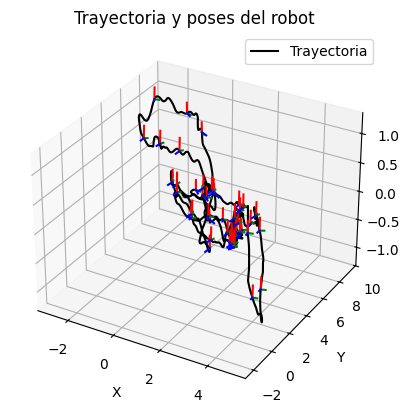

In [5]:

# -------------------------------
# Configurar figura 3D
# -------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Trayectoria y poses del robot")

# Graficar trayectoria
ax.plot(positions[:,0], positions[:,1], positions[:,2], 'k-', label="Trayectoria")

# -------------------------------
# Graficar algunos frames de orientación
# -------------------------------
scale = 0.2  # longitud de los ejes dibujados
step = max(1, len(df)//50)  # muestreo para no saturar la gráfica

for i in range(0, len(df), step):
    pos = positions[i]
    quat = quaternions[i]
    rot = R.from_quat(quat).as_matrix()

    # Ejes locales (en base a la orientación del robot)
    x_axis = pos + rot[:,0] * scale
    y_axis = pos + rot[:,1] * scale
    z_axis = pos + rot[:,2] * scale

    # Dibujar ejes de orientación
    ax.plot([pos[0], x_axis[0]], [pos[1], y_axis[1]], [pos[2], x_axis[2]], 'r')
    ax.plot([pos[0], y_axis[0]], [pos[1], y_axis[1]], [pos[2], y_axis[2]], 'g')
    ax.plot([pos[0], z_axis[0]], [pos[1], z_axis[1]], [pos[2], z_axis[2]], 'b')

plt.legend()
plt.show()


Grafico las trayectorias respecto al tiempo

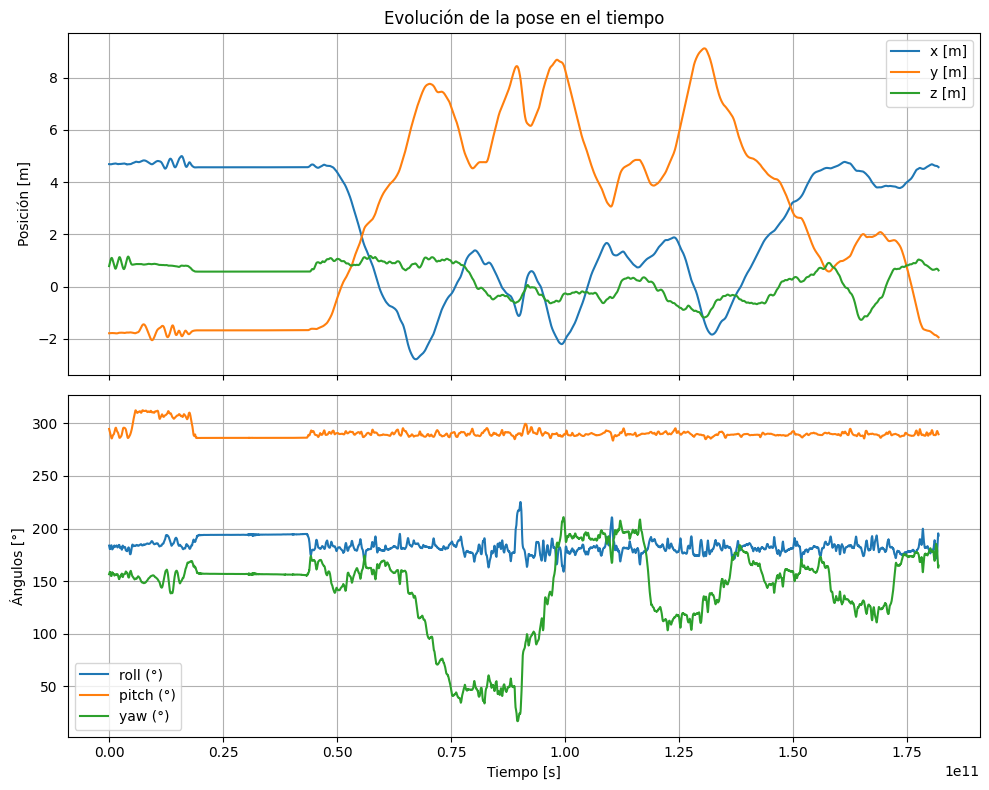

In [6]:
# -------------------------------
# Configurar figuras en función del tiempo
# -------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# Graficar posiciones
axs[0].plot(time, positions[:,0], label="x [m]")
axs[0].plot(time, positions[:,1], label="y [m]")
axs[0].plot(time, positions[:,2], label="z [m]")
axs[0].set_ylabel("Posición [m]")
axs[0].set_title("Evolución de la pose en el tiempo")
axs[0].grid(True)
axs[0].legend()

# -------------------------------
# Convertir cuaterniones a ángulos de Euler
# -------------------------------
# -------------------------------
# Convertir cuaterniones a ángulos de Euler
# -------------------------------
eulers = R.from_quat(quaternions).as_euler("xyz", degrees=True)

# Modifico el rango de los angulos para que se vea de forma continua en la grafica. Por defecto son de -180 a 180
# Normalizar a [0, 360)
eulers = (eulers + 360) % 360

# Graficar orientaciones
axs[1].plot(time, eulers[:,0], label="roll (°)")
axs[1].plot(time, eulers[:,1], label="pitch (°)")
axs[1].plot(time, eulers[:,2], label="yaw (°)")
axs[1].set_xlabel("Tiempo [s]")
axs[1].set_ylabel("Ángulos [°]")
axs[1].grid(True)
axs[1].legend()


plt.tight_layout()
plt.show()


En los archivos "sensor.yaml" se describe la pose del sensor mediante una transformacion homogenea.

En dicho archivo se expresa la tranformacion del marco del `sensor` al marco del `robot`.

La camara izquierda del robot, considreando las coordenadas cartecianas del sistema de coordenadas del robot (x adelante, y izquierda y z arriba) y dado que la transformacion que se exoresa es del sensor al robot, se entiende que la camara izquierda es el sensor que tiene el elemento (2,4) negativo de la matriz de transformacion homogenea (cam0)



In [15]:

#df_cam0 = pd.read_csv("C:/Users/Geronimo/Downloads/mav0/cam0/data.csv")

# matriz de transformacion homogenea extraida de .../cam0/sensor.yalm
# transforma coordenadas del sensor -> coordenadas del body
S_T_B = np.array([
    [0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975],
    [0.999557249008, 0.0149672133247, 0.025715529948, -0.064676986768],
    [-0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949],
    [0.0, 0.0, 0.0, 1.0]
])

# Calculo la transformacion inversa
# transforma coordenadas del body -> coordenadas del sensor
B_T_S = np.linalg.inv(S_T_B)
print(B_T_S)


[[ 0.01486554  0.99955725 -0.02577444  0.06522291]
 [-0.99988093  0.01496721  0.00375619 -0.02070639]
 [ 0.0041403   0.02571553  0.99966073 -0.0080546 ]
 [ 0.          0.          0.          1.        ]]


In [8]:

import transforms3d as t3

# T_SB = np.linalg.inv(S_T_B)
T_SB = np.linalg.inv(S_T_B)
R_SB = T_SB[:3, :3]

# Reordenar quaterniones del CSV a formato transforms3d (w, x, y, z)
quaternions_t3 = quaternions[:, [3,0,1,2]]   # (qw, qx, qy, qz) → (w, x, y, z)

# Convertir cada orientación del body al sensor
rot_sensor_quats = []
for q in quaternions_t3:
    R_body = t3.quaternions.quat2mat(q)       # body->world
    R_sensor = R_SB @ R_body                  # sensor->world
    q_sensor = t3.quaternions.mat2quat(R_sensor)  # (w, x, y, z)
    rot_sensor_quats.append(q_sensor)

rot_sensor_quats = np.array(rot_sensor_quats)


In [9]:
def transform_points(positions, T):
    """Transforma un conjunto de puntos Nx3 usando matriz homogénea 4x4."""
    n = positions.shape[0]
    homo = np.hstack([positions, np.ones((n,1))])  # Nx4
    transformed = (T @ homo.T).T
    return transformed[:, :3]

positions_sensor = transform_points(positions, B_T_S)

In [10]:
# Convertir a ángulos Euler (xyz, en grados)
eulers_sensor = np.array([
    t3.euler.mat2euler(t3.quaternions.quat2mat(q), axes='sxyz')
    for q in rot_sensor_quats
])

# rad → deg
eulers_sensor = np.degrees(eulers_sensor)

# Normalizar a [0, 360)
eulers_sensor = (eulers_sensor + 360) % 360


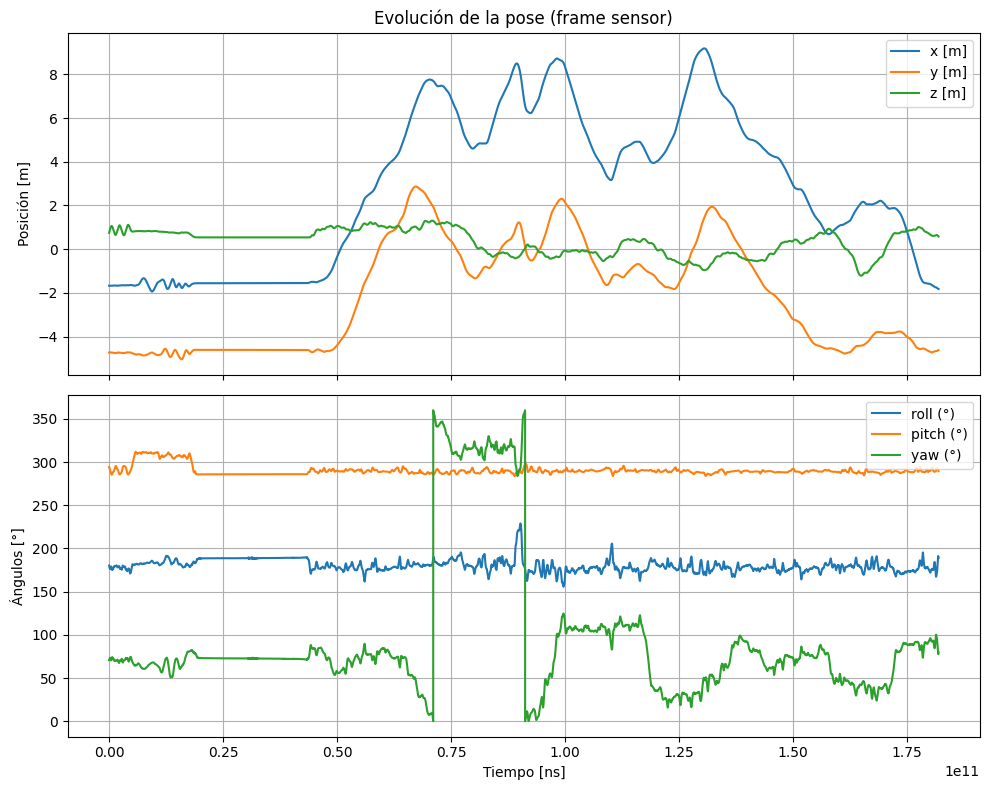

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# Posiciones
axs[0].plot(time, positions_sensor[:,0], label="x [m]")
axs[0].plot(time, positions_sensor[:,1], label="y [m]")
axs[0].plot(time, positions_sensor[:,2], label="z [m]")
axs[0].set_ylabel("Posición [m]")
axs[0].set_title("Evolución de la pose (frame sensor)")
axs[0].grid(True)
axs[0].legend()

# Orientaciones
axs[1].plot(time, eulers_sensor[:,0], label="roll (°)")
axs[1].plot(time, eulers_sensor[:,1], label="pitch (°)")
axs[1].plot(time, eulers_sensor[:,2], label="yaw (°)")
axs[1].set_xlabel("Tiempo [ns]")
axs[1].set_ylabel("Ángulos [°]")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


## B)
Modifique el script para que el timestamp del nuevo ground-truth este en segundos con precisión de nanosegundos. Agregar las primeras 5 filas del ground-truth resultante y las del original del dataset al informe.

In [14]:

# Pasar a segundos (float con resolución de ns)
df["timestamp_s"] = df["#timestamp"] / 1e9
df.head()

,#timestamp,p_RS_R_x [m],p_RS_R_y [m],p_RS_R_z [m],q_RS_w [],q_RS_x [],q_RS_y [],q_RS_z [],v_RS_R_x [m s^-1],v_RS_R_y [m s^-1],v_RS_R_z [m s^-1],b_w_RS_S_x [rad s^-1],b_w_RS_S_y [rad s^-1],b_w_RS_S_z [rad s^-1],b_a_RS_S_x [m s^-2],b_a_RS_S_y [m s^-2],b_a_RS_S_z [m s^-2],timestamp_s
0,1403636580838555648,4.688319,-1.786938,0.783338,0.534108,-0.153029,-0.827383,-0.082152,-0.027876,0.033207,0.800006,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593,1.403637e+09
1,1403636580843555328,4.688177,-1.786770,0.787350,0.534640,-0.152990,-0.826976,-0.082863,-0.029272,0.033992,0.804771,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593,1.403637e+09
2,1403636580848555520,4.688028,-1.786598,0.791382,0.535178,-0.152945,-0.826562,-0.083605,-0.030043,0.034999,0.808240,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593,1.403637e+09
3,1403636580853555456,4.687878,-1.786421,0.795429,0.535715,-0.152884,-0.826146,-0.084391,-0.030230,0.035853,0.810462,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593,1.403637e+09
4,1403636580858555648,4.687727,-1.786240,0.799484,0.536244,-0.152821,-0.825731,-0.085213,-0.029905,0.036316,0.811406,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593,1.403637e+09


In [19]:
df_cam0 =  pd.DataFrame({
    "timestamp_s": df["#timestamp"] / 1e9,
    "posicion_cam_X":positions_sensor[:,0],
    "posicion_cam_Y":positions_sensor[:,1],
    "posicion_cam_Z":positions_sensor[:,2],
    "orientacion_w": rot_sensor_quats[:,0], # el quat esta definido como (w,x,y,z)
    "orientacion_z": rot_sensor_quats[:,1],
    "orientacion_y": rot_sensor_quats[:,2],
    "orientacion_z": rot_sensor_quats[:,3],
})


In [ ]:
df_cam0.head()

,timestamp_s,posicion_cam_X,posicion_cam_Y,posicion_cam_Z,orientacion_w,orientacion_z,orientacion_y
0,1.403637e+09,-1.671420,-4.732270,0.748477,0.315288,-0.441312,-0.486932
1,1.403637e+09,-1.671357,-4.732111,0.752491,0.315172,-0.442188,-0.486669
2,1.403637e+09,-1.671291,-4.731944,0.756525,0.315038,-0.443090,-0.486406
3,1.403637e+09,-1.671221,-4.731776,0.760575,0.314873,-0.444023,-0.486152
4,1.403637e+09,-1.671147,-4.731607,0.764633,0.314676,-0.444976,-0.485899


In [23]:
df.head()

,#timestamp,p_RS_R_x [m],p_RS_R_y [m],p_RS_R_z [m],q_RS_w [],q_RS_x [],q_RS_y [],q_RS_z [],v_RS_R_x [m s^-1],v_RS_R_y [m s^-1],v_RS_R_z [m s^-1],b_w_RS_S_x [rad s^-1],b_w_RS_S_y [rad s^-1],b_w_RS_S_z [rad s^-1],b_a_RS_S_x [m s^-2],b_a_RS_S_y [m s^-2],b_a_RS_S_z [m s^-2]
0,1403636580838555648,4.688319,-1.786938,0.783338,0.534108,-0.153029,-0.827383,-0.082152,-0.027876,0.033207,0.800006,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593
1,1403636580843555328,4.688177,-1.786770,0.787350,0.534640,-0.152990,-0.826976,-0.082863,-0.029272,0.033992,0.804771,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593
2,1403636580848555520,4.688028,-1.786598,0.791382,0.535178,-0.152945,-0.826562,-0.083605,-0.030043,0.034999,0.808240,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593
3,1403636580853555456,4.687878,-1.786421,0.795429,0.535715,-0.152884,-0.826146,-0.084391,-0.030230,0.035853,0.810462,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593
4,1403636580858555648,4.687727,-1.786240,0.799484,0.536244,-0.152821,-0.825731,-0.085213,-0.029905,0.036316,0.811406,-0.003172,0.021267,0.078502,-0.025266,0.136696,0.075593


Formato para exportar en latex, uso la funcion `to_latex` para luego exportar la salida ya en un formato compatible con latex

In [41]:
latex_table = df_cam0.head(5).to_latex(index=False, float_format="%.9f", escape=True)

print(latex_table)


\begin{tabular}{rrrrrrr}
\toprule
timestamp\_s & posicion\_cam\_X & posicion\_cam\_Y & posicion\_cam\_Z & orientacion\_w & orientacion\_z & orientacion\_y \\
\midrule
1403636580.838555574 & -1.671419610 & -4.732270263 & 0.748476607 & 0.315287845 & -0.441312086 & -0.486932005 \\
1403636580.843555212 & -1.671357202 & -4.732110696 & 0.752490978 & 0.315171715 & -0.442188176 & -0.486669417 \\
1403636580.848555565 & -1.671291416 & -4.731943994 & 0.756525416 & 0.315038115 & -0.443090417 & -0.486405851 \\
1403636580.853555441 & -1.671221033 & -4.731776161 & 0.760574974 & 0.314872794 & -0.444023073 & -0.486151694 \\
1403636580.858555555 & -1.671146873 & -4.731607239 & 0.764632627 & 0.314676366 & -0.444975574 & -0.485899108 \\
\bottomrule
\end{tabular}



In [40]:
df_head = df.head(5)  # solo primeras 5 filas

cols_per_table = 6  # número de columnas por subtabla
latex_tables = []

# Partir columnas en bloques de 7
for i in range(0, df_head.shape[1], cols_per_table):
    df_part = df_head.iloc[:, i:i+cols_per_table]
    # Convertir a LaTeX
    latex_str = df_part.to_latex(index=False, float_format="%.6f", escape=True)
    latex_tables.append(latex_str)

# Mostrar cada subtabla
for idx, table in enumerate(latex_tables):
    print(f"\n% ---- Subtabla {idx+1} ----\n")
    print(table)


% ---- Subtabla 1 ----

\begin{tabular}{rrrrrr}
\toprule
\#timestamp &  p\_RS\_R\_x [m] &  p\_RS\_R\_y [m] &  p\_RS\_R\_z [m] &  q\_RS\_w [] &  q\_RS\_x [] \\
\midrule
1403636580838555648 & 4.688319 & -1.786938 & 0.783338 & 0.534108 & -0.153029 \\
1403636580843555328 & 4.688177 & -1.786770 & 0.787350 & 0.534640 & -0.152990 \\
1403636580848555520 & 4.688028 & -1.786598 & 0.791382 & 0.535178 & -0.152945 \\
1403636580853555456 & 4.687878 & -1.786421 & 0.795429 & 0.535715 & -0.152884 \\
1403636580858555648 & 4.687727 & -1.786240 & 0.799484 & 0.536244 & -0.152821 \\
\bottomrule
\end{tabular}


% ---- Subtabla 2 ----

\begin{tabular}{rrrrrr}
\toprule
 q\_RS\_y [] &  q\_RS\_z [] &  v\_RS\_R\_x [m s\textasciicircum -1] &  v\_RS\_R\_y [m s\textasciicircum -1] &  v\_RS\_R\_z [m s\textasciicircum -1] &  b\_w\_RS\_S\_x [rad s\textasciicircum -1] \\
\midrule
-0.827383 & -0.082152 & -0.027876 & 0.033207 & 0.800006 & -0.003172 \\
-0.826976 & -0.082863 & -0.029272 & 0.033992 & 0.804771 & -0.003172 \\